# Sinton Lifetime Analyser

This code opens a series of Sinton Lifetime Excel files, saves them into a panda dataframe, and displays a dash plot where the different files can be explored. 

You can then choose which of the files to analyse and plot separately.

First we start by importing some useful libraries.

In [11]:
import numpy as np
import matplotlib
import pandas as pd
import os
import warnings

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# the library below is not standard, and needs to be added to the same folder.
import lifetime_functions_13 as tau_func
# additionally make sure that the 'SiliconData.mat' file also exists in the same folder.

 ### Now let's check all .xlsm files in a folder, and get a list of the files we will analyse. It gives the chance of adding or deleting files

In [12]:
# since the macro files from Sinton have some warnings, best to ignore them
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# Create a dictionary to hold the dataframes
excel_files = {}

#select a folder (remember in python you need \\ for the folder path)
folder_path = 'C:\\Users\\corp1959\\OneDrive - Nexus365\\PYTHON\\lifetime_analyser\\data_examples\\Yan_Aug2024'
#folder_path = 'C:\\Users\\corp1959\\Downloads\\Sebastian'

#folder_path = 'C:\\Users\\Sebastian\\OneDrive - Nexus365\\PYTHON\\lifetime_analyser\\Ana-lifetime'

print(folder_path)

# Loop through all files in a directory selected by the user
for file in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file.endswith('.xlsm'):
        # Create a dataframe from the Excel file
        file_path = os.path.join(folder_path, file)
        excel_files[file] = pd.read_excel(file_path)
print("Loaded Excel files:")
for file_name in excel_files:
    print(file_name)

C:\Users\corp1959\OneDrive - Nexus365\PYTHON\lifetime_analyser\data_examples\Yan_Aug2024
Loaded Excel files:
Take 2-0723-C-2.xlsm
Take 2-0723-D-2.xlsm


### Plot all of the lifetimes into a single plot that allows exploring the data.
If you get errors here it is likely some of the Excel Sinton files are corrupted or are using an older version of the software.

reading:  Take 2-0723-C-2.xlsm
reading:  Take 2-0723-D-2.xlsm


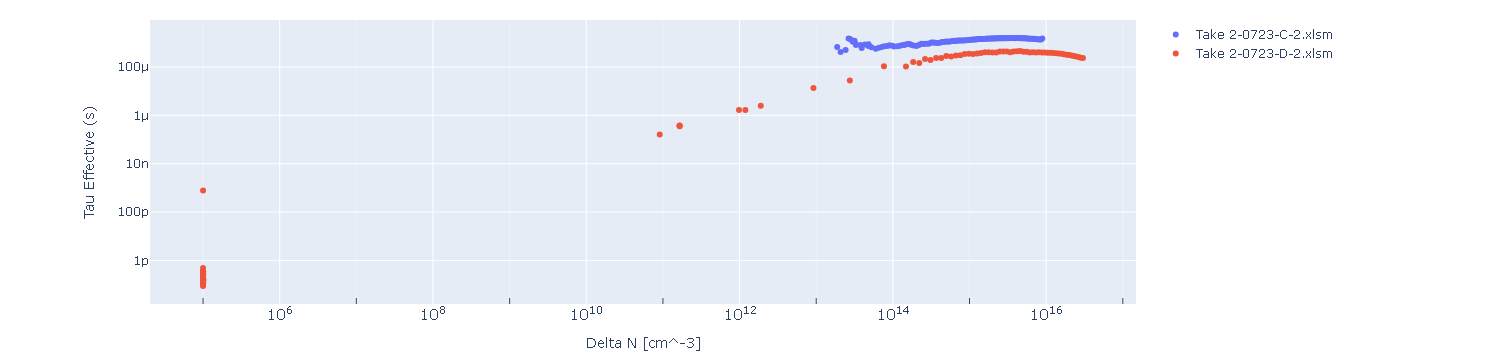

In [13]:
df_lib = {}# library of all the data_frames lodaded

# Create a Plotly figure with subplots
fig = make_subplots()
fig.update_xaxes(type='log',exponentformat = 'power'); fig.update_yaxes(type='log')
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, showgrid=True))
fig.update_xaxes(title_text="Delta N [cm^-3]"); fig.update_yaxes(title_text="Tau Effective (s)")

for file_name in excel_files:
    print("reading: ",file_name)
    file_path = os.path.join(folder_path, file_name)
    df1=pd.read_excel(file_path ,sheet_name='RawData')
    df3=pd.read_excel(file_path, sheet_name='User',nrows=1,header=4)

    #create a new dataframe that has all information of a single sample in it.
    trunc_ix=3; #remove the first and last 3 values of the lifetime plot.
    df = pd.DataFrame({df3.iloc[0,0]:#sample name
        [df3.iloc[0,1],#thickness in cm
        df3.iloc[0,2],#resisitivity in ohm.cm
        df3.iloc[0,3],#Si type
        df1['Minority Carrier Density'].iloc[trunc_ix:-trunc_ix],#iloc[4]: Delta_n
        df1['Tau (sec)'].iloc[trunc_ix:-trunc_ix],#iloc[5]: Teff
        df1['Implied Voc'].iloc[trunc_ix:-trunc_ix],#iloc[6]: iVoc
        df1['Implied Suns'].iloc[trunc_ix:-trunc_ix]]})#iloc[7]: iSuns
    
    df_lib[file_name]=df
    sample_name=df.columns[0]
    delta_n=df.iloc[3,0]
    tau_eff=df.iloc[4,0]
    fig.add_trace(go.Scatter(x=delta_n, y=tau_eff, mode='markers', name=file_name))

fig.update_layout(
    margin=dict(l=150, r=350, t=20, b=20),
    paper_bgcolor="white",
)
fig.show()

## Decide which excel file you would like to analyse to get the Surface Recombination parameters
To make sure it is all clear, here are all the main equations that define how these parameters are analysed.
### See more on
- RS Bonilla, et al (2017), Phys. Status Solidi A, 214: 1700293
- A. Kimmerle, J. Greulich, and A. Wolf, Sol. Energy Mater. Sol. Cells 142, 116–122 (2015).
- H. M€ackel and K. Varner, Prog. Photovolt. Res. Appl. 21, 850–866 (2013).
- B. Hammann et al., IEEE Journal of Photovoltaics, vol. 13, no. 4, pp. 535-546, July 2023.)



Starting from the effective lifetime measured in a Sinton tester $ \frac{1}{\tau_{eff}}=\frac{1}{\tau_{bulk_int}}+\frac{1}{\tau_{SRH}}+\frac{1}{\tau_{surf}} $.

Effective recombinaiton velocity is: $S_{eff}=\sqrt{D(\frac{1}{\tau_{surf}})}*\tan(W/2\sqrt{(\frac{1}{D\tau_{surf}})})$.  Which is often approximated to $S_{eff}=W/2(\frac{1}{\tau_{surf}})$

Then, J0 can be estimate from the average of the flat region of a plot of: $\frac{\partial}{\partial \Delta n}(n_i^2(S_{eff}))$ which requires the algorithm implemented for getting $J_{0S-avg}$, since we need to calculate an SRH recombination that makes  $J_{0s-avg}=\frac{qn_i^2S_{eff}}{N_{dop}+\Delta n} $ a true equation. Here $J_0$ would be a single value parameter, but it is of course possible to simply calculate S and then obtain a J0 as a function of minority carriers. 

Some useful advice for extracting J0:
 
- Start by letting the software fit the tn, tp, and E_t values.
- Check that the fit makes sense in the figure. Remember this code does not fit lifetime, it finds the SRH term that is most compatible with a carrier-independent J_0s average term, as per Kimmerle's method.
- If you are doing many samples at the same time, and you cannot check all of them, start on the assumption that they all have the same bulk lifetime.
- This means setting a strict value of the SRH bulk via tn, tp, and E_t.
- Often you can find out how much defect mediated recombination sample have based on a sample with reasonable passivation (J0s<10 fA/Cm2)
- Then use this to fit the best possible SRH, and analyse all samples with a single value of SRH bulk.
- Conversely, if your processes aim to change the bulk, but you have a good confidence of the surface passivation, then set the value of J0s and allow the fitted to find the best recombination parameters it can find. 

In [17]:
# Enter a fileID number from 0 to (max files - 1), and the app will analyse such file.
file_ID=0
files_in= list(df_lib.keys())
print(f"Analysing File ID number {file_ID}: {files_in[file_ID]}")  # Output: Key at index 1: b

# change the plot_options=0 if you do not want to plot the result of the analysis
plot_option=1;

# set any options for the fitting of SRH lifetime using the array below
#srh_fit_options=np.array([0.01,0.01,0.5,0]) # specify values of tn [s], tp [s], Et-Ev [eV], J0 [A/cm2] (leave as zero for fitting)
srh_fit_options=np.array([0,0,0,0]) # specify values of tn [s], tp [s], Et-Ev [eV], J0 [A/cm2] (leave as zero for fitting)

try:
    results_df=tau_func.extract_srv(df_lib[files_in[file_ID]],plot_option,srh_fit_options)

except Exception as e:
    print(f"\n \n **** Error processing {files_in[file_ID]}: {e} ****\n \n ")

# after finishing the fit, the algorithm will state if it finished by finding the smallest variation in the function (ftol) 
# aim for MSE's velu 1e-6  (the lower the better)
# print(results_df)

Analysing File ID number 0: Take 2-0723-C-2.xlsm
High SRV or wrong gGradient - J_0 calculated from Seff instead of gradient
High SRV or wrong gGradient - J_0 calculated from Seff instead of gradient
Take 2-0723-C-2
`xtol` termination condition is satisfied.
The values of tn [s], tp [s], Et-Ev [eV], J0 [A/cm2] are
[array([0.00101875, 0.00075202, 0.5573012 ]), 1.9325820978485513e-16]

 
 **** Error processing Take 2-0723-C-2.xlsm: x and y arrays must be equal in length along interpolation axis. ****
 
 


## if you would like to save the results into a csv file run the cell below

In [5]:
tau_func.save_file(results_df,file_name.replace('.xlsm', '.csv'))

## If you would like to analyse all of the files inside of the folder, you can use the cell below.
Execute carefully as it may take a long time to analyse very big folders.

In [ ]:
delta_n_key=1e15 # you need to define at which Delta_N all resuls should be reported

#then execute the below to do the analysis
df_lib_results = {'variable':[['T_eff'],['S_eff1'],['S_eff2'],['S_eff3'],['J0avg'],['J0_Kimmerle2'],['iVoc'],['mse'],['SRH']]}# library of all the analysed results
                  
for file_name in df_lib:
    try:
        results_df=tau_func.extract_srv(df_lib[file_name],0,srh_fit_options)

        # extracting all variables and defining by name
        sample_name=results_df.columns[0]
        delta_n=results_df.iloc[3,0]
        tau_eff=results_df.iloc[4,0]
        waf_thick=results_df.iloc[0,0]
        delta_n2=results_df.loc[5,sample_name]
        t_int=results_df.loc[6,sample_name]
        nieff=results_df.loc[7,sample_name]
        ndop=results_df.loc[8,sample_name]
        Joe_avg=results_df.loc[9,sample_name]
        tau_SRH=results_df.loc[10,sample_name]
        [[Seff_1],[Seff_2],[Seff_3]]=results_df.loc[11,sample_name]
        [[Joe6],[Joe2],[Joe1]]=results_df.loc[12,sample_name]
        iVoc=results_df.loc[13,sample_name]
        tau_eff2=results_df.loc[14,sample_name]
        SRH_parms=results_df.loc[15,sample_name]
        mse=results_df.loc[16,sample_name]
        SunsVoc=results_df.loc[17,sample_name]

        df_lib_results[file_name]=[[np.interp(delta_n_key,delta_n2,tau_eff2)],
                                   [np.interp(delta_n_key,delta_n2,Seff_1)],
                                   [np.interp(delta_n_key,delta_n2,Seff_2)],
                                   [np.interp(delta_n_key,delta_n2,Seff_3)],
                                   [Joe_avg],
                                   [np.interp(delta_n_key,delta_n2,Joe2)],
                                   [np.interp(delta_n_key,delta_n2,iVoc)],[mse],[SRH_parms]
                                ]
    except Exception as e:
        print(f"\n \n Error processing {file_name}: {e}\n \n ")
    continue

In [ ]:
#and finally execute this to save all your analysed results to an excel file.

data_exp_name='data_out.xlsx'
j0s.export_xls(dev1,rec_lib, Dn_vec, Qf_vec,data_exp_name)
